In [17]:
import os
import sys
import numpy as np
import pandas as pd
import math
import sys
import pickle
import csv

import dask.dataframe as dd
from dask.distributed import Client

import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule
from pyro.infer import Predictive

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, '/home/djl34/lab_pd/kl/git/KL/scripts')
import raklette
from run_raklette import run_raklette
from run_raklette import TSVDataset

import post_analysis

sys.path.insert(0, '/home/djl34/lab_pd/simulator/code')
from others import round_sig

import seaborn as sns
import matplotlib.pyplot as plt

##############################################################################################################
## Useful transformations
####################################################
pad = torch.nn.ConstantPad1d((1,0), 0.)           # Add a 0 to a tensor
softmax = torch.nn.Softmax(-1)                    # softmax transform along the last dimension
relu = torch.nn.ReLU()                            # map everything < 0 -> 0
order_trans = dist.transforms.OrderedTransform()  # y_0=x_0; y_i=y_0+sum_j=1^i exp(x_j) [not really used anymore, weird properties]


KL_data_dir = "/home/djl34/lab_pd/kl/data"
scratch_dir = "/n/scratch3/users/d/djl34"

base_set = ["A", "C", "T", "G"]
chrom_set = [str(x) for x in range(1, 23)]

file_directory = "single_feature/zoonomia/"

In [2]:
client = Client()

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41577 instead
  warnings.warn(


## get beta

In [3]:
chrom_set = ["-2"]

interval_list = range(20)
interval_list = [x/20 for x in interval_list]
interval_list = [str(x) + "_" + str(round_sig(x + 0.05, 2)) for x in interval_list]


header = "gene_edges_"


In [4]:
covprior_list = [0.1]
learning_rate_list = [0.01]


sample_size = 100000000
chunksize = 100000
epoch = 5

header_list = []

def get_file_header(header, chrom, sample_size, lr, gamma, chunksize, epoch, cov_prior):
    return os.path.join(KL_data_dir, "raklette_output/" + file_directory + header + chrom + "_sample_"+ 
                        str(sample_size) + "_covonly_lr_" + str(lr) + "_gamma_" + str(gamma) +"_chunksize_"+ str(chunksize)+"_epoch_" + 
                        str(epoch)+ "_covprior_" + str(cov_prior))
    

for interval in interval_list:
    for prior in covprior_list:
#         print(prior)
        for lrate in learning_rate_list:
#             print(lrate)
            for chrom in chrom_set:
                lr, gamma, cov_prior, chrom = (lrate, 0.5, prior, chrom)

                file_header = get_file_header(header + interval + "_only_", chrom, sample_size, lr, gamma, chunksize, epoch, cov_prior)

                header_list.append(file_header)

## check for fit

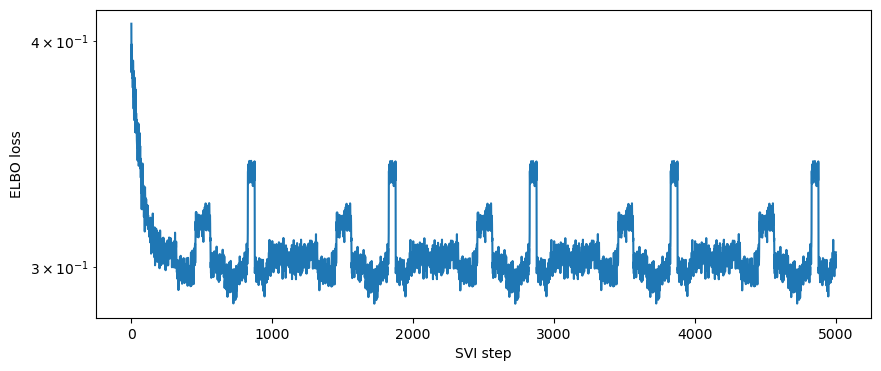

In [5]:
with open(header_list[0] + ".pkl", 'rb') as handle:
            dictionary = pickle.load(handle)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


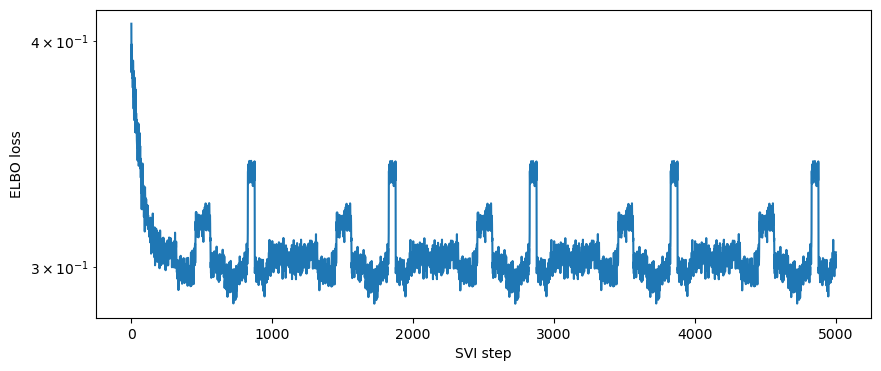

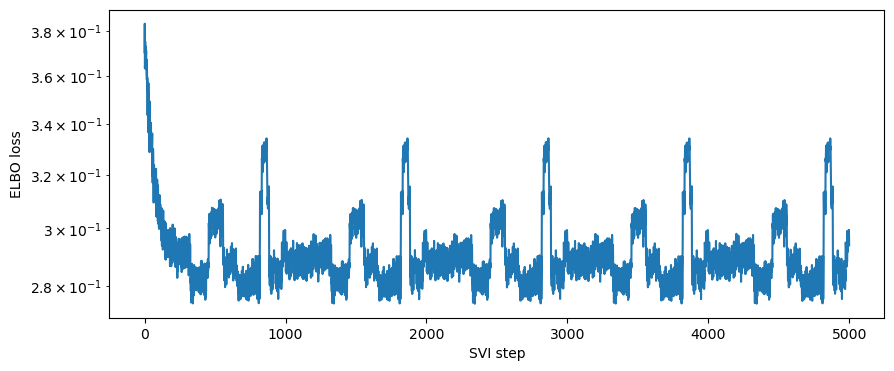

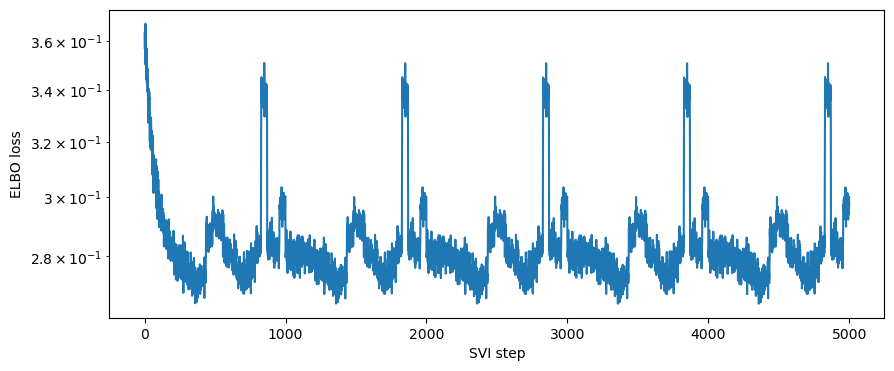

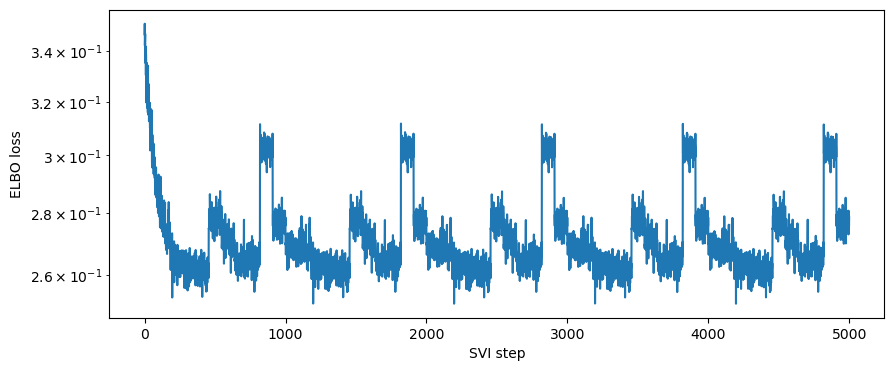

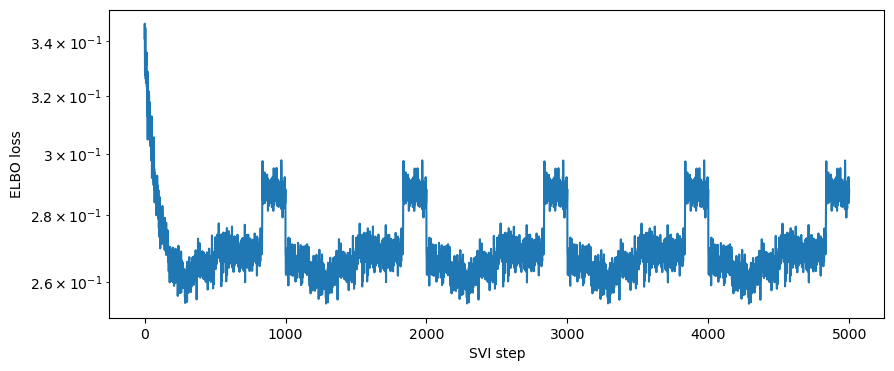

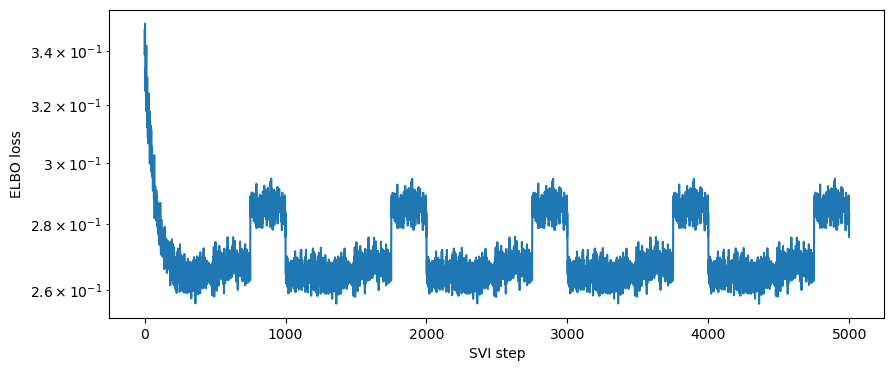

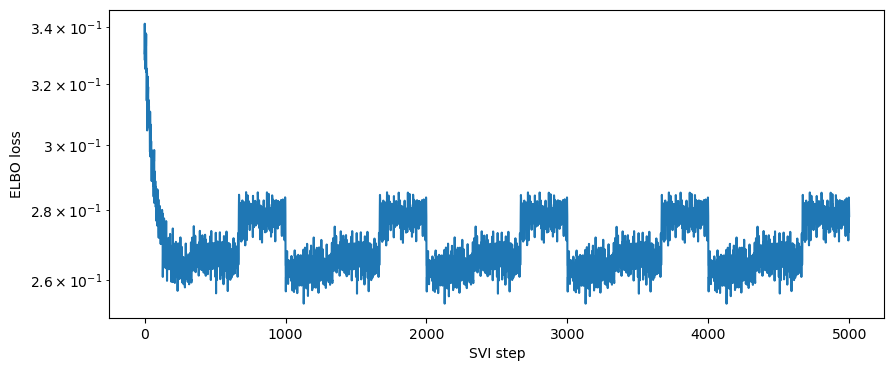

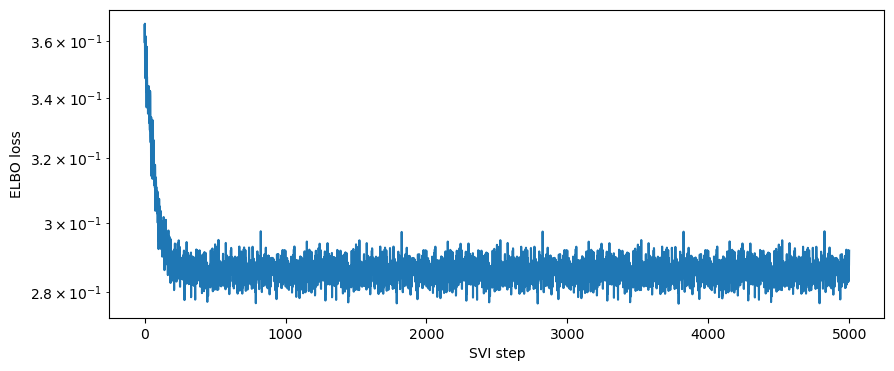

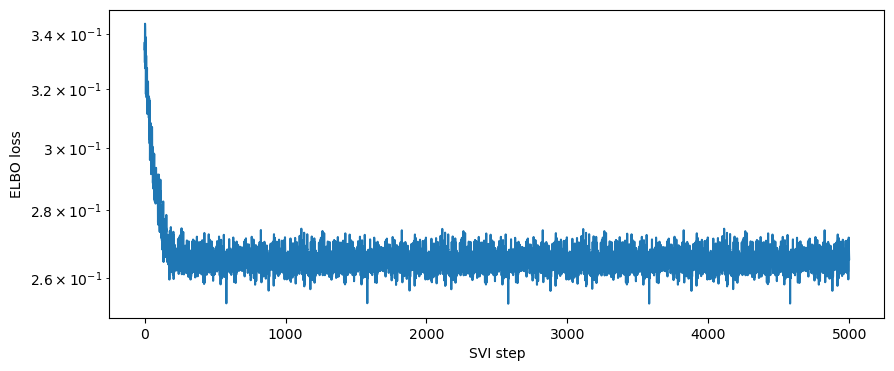

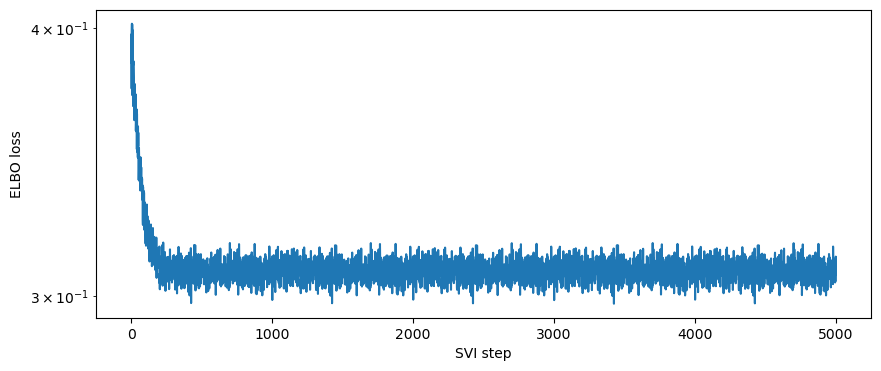

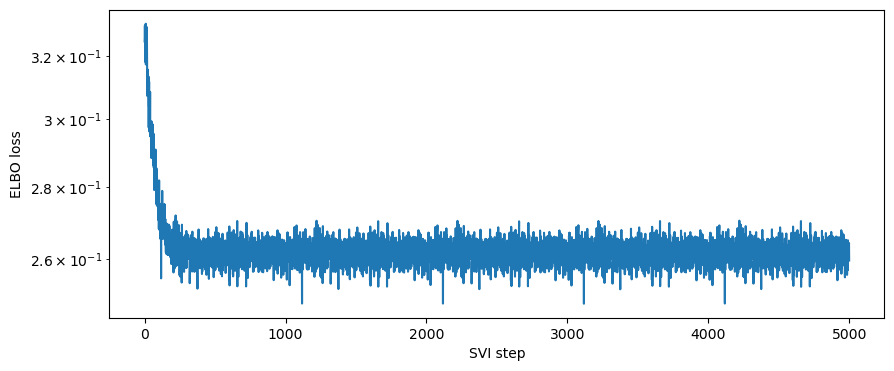

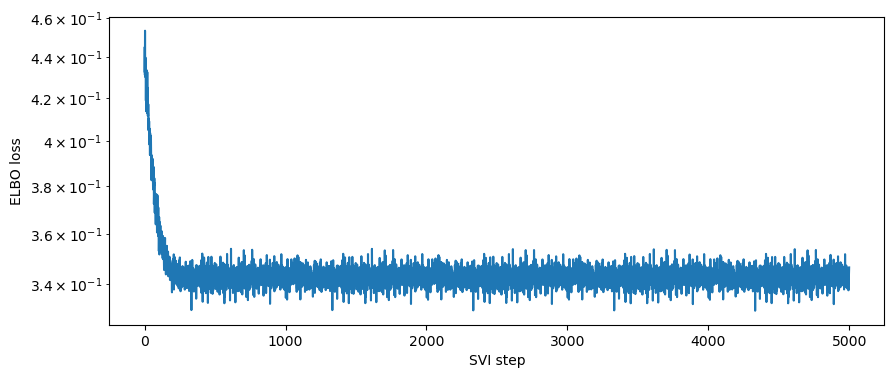

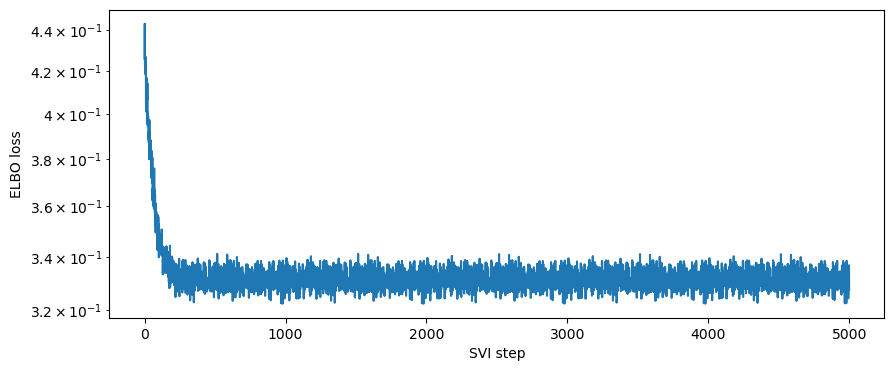

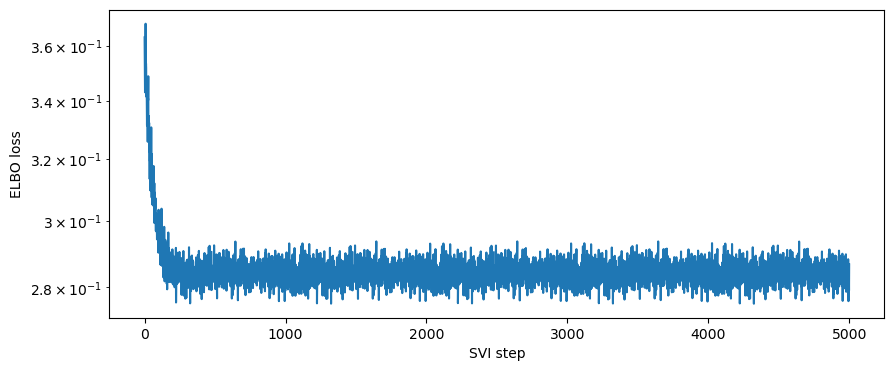

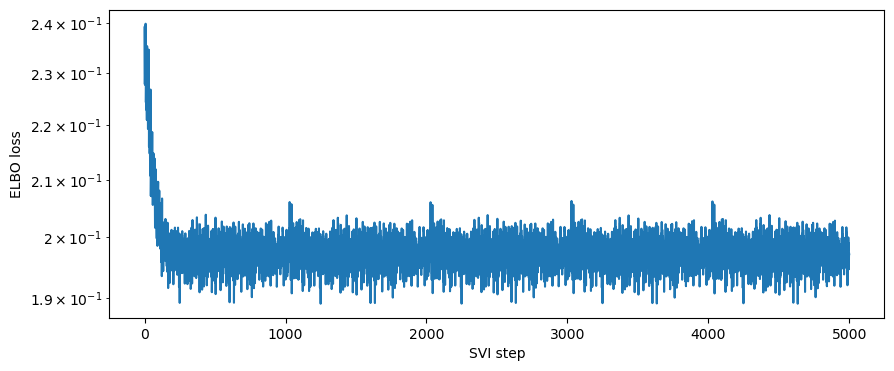

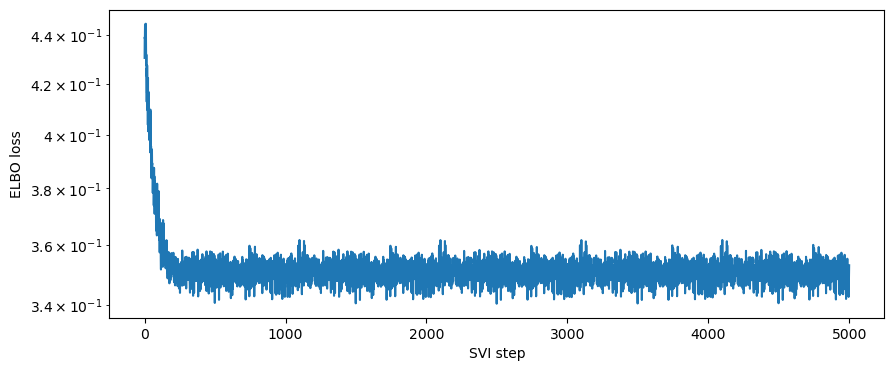

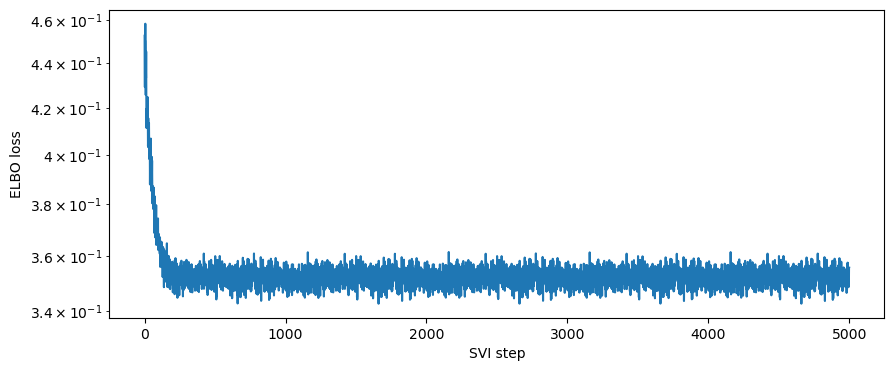

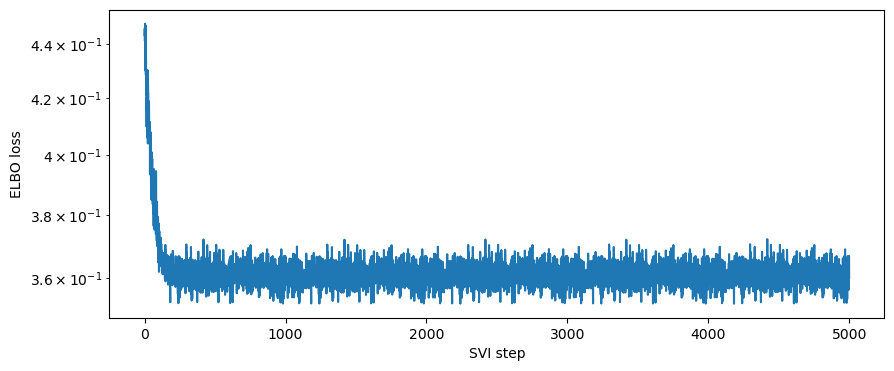

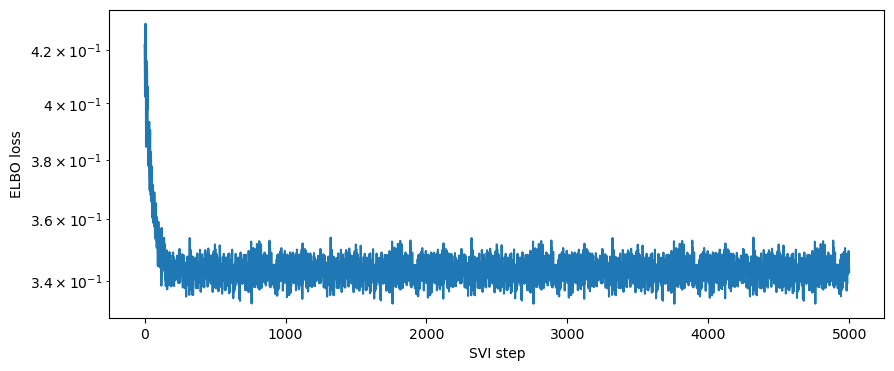

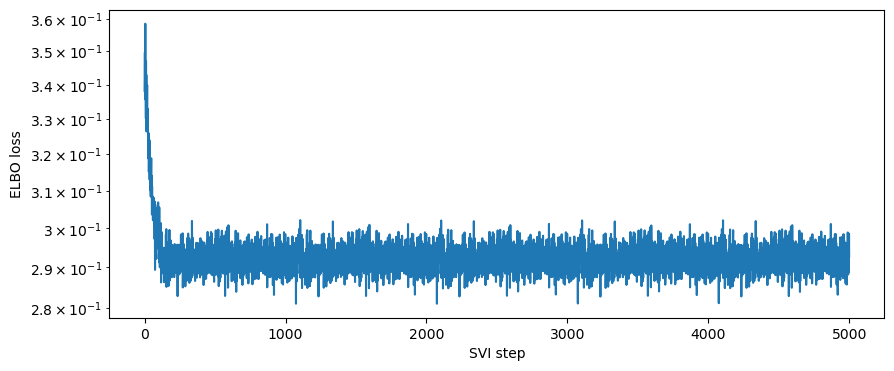

In [6]:
for i in range(len(header_list)):
    print(i)
    try:
        with open(header_list[i] + ".pkl", 'rb') as handle:
            dictionary = pickle.load(handle)
    except:
        print("continue")
        continue

## get_fit_values

In [7]:
def read_model(file_header):
    
    with open(file_header + ".model", 'rb') as handle:
        dictionary = pickle.load(handle)
    
    return dictionary

def get_n_cov(dictionary):
    
    guide = dictionary["guide"]
    KL = dictionary["KL"]
    model = dictionary["model"]

    beta_neut = KL.beta_neut
    beta_neut_full = KL.beta_neut_full
    beta_cov = guide.median()['beta_cov']
    
    return beta_cov.shape[0]

def get_beta_cov_trans(dictionary):
    
    with open(file_header + ".model", 'rb') as handle:
        dictionary = pickle.load(handle)
    
    guide = dictionary["guide"]
    KL = dictionary["KL"]
    model = dictionary["model"]

    beta_neut = KL.beta_neut
    beta_neut_full = KL.beta_neut_full
    beta_cov = guide.median()['beta_cov']
    
    beta_cov_trans = torch.cumsum(beta_cov, dim=-1)
    
    return beta_cov_trans

def get_n_sites(file_header):
    
    variants = "/n/scratch3/users/d/djl34/kl_input/"+ file_directory + file_header + "_length.tsv"
    
#     print(variants)
    
    df = pd.read_csv(variants, sep = "\t", header = None)
        
    return int(df.iloc[0, 0])
    

In [8]:
list_of_list = []

for interval in interval_list:
    for prior in covprior_list:
        print(prior)
        for lrate in learning_rate_list:
            print(lrate)
            for chrom in chrom_set:
                header_added = header + interval + "_only_"
                
                lr, cov_prior, chrom = (lrate, prior, chrom)

                file_header = get_file_header(header_added, chrom, sample_size, lr, gamma, chunksize, epoch, cov_prior)

                print(file_header)


                list_row = []
#                 list_row.append(prior)
#                 list_row.append(lr)
                list_row.append(interval)

                dictionary = read_model(file_header)        
                n_cov = get_n_cov(dictionary)
                beta_cov_trans = get_beta_cov_trans(dictionary)

                for i in range(n_cov):
                    for j in range(beta_cov_trans.shape[1]):
                        list_row.append(round_sig(float(beta_cov_trans[i, j]), 2))

#                 list_row.append(get_n_sites(header_added + chrom + "_sample_" + str(sample_size)))

                list_of_list.append(list_row)



0.1
0.01
/home/djl34/lab_pd/kl/data/raklette_output/single_feature/zoonomia/gene_edges_0.0_0.05_only_-2_sample_100000000_covonly_lr_0.01_gamma_0.5_chunksize_100000_epoch_5_covprior_0.1
0.1
0.01
/home/djl34/lab_pd/kl/data/raklette_output/single_feature/zoonomia/gene_edges_0.05_0.1_only_-2_sample_100000000_covonly_lr_0.01_gamma_0.5_chunksize_100000_epoch_5_covprior_0.1
0.1
0.01
/home/djl34/lab_pd/kl/data/raklette_output/single_feature/zoonomia/gene_edges_0.1_0.15_only_-2_sample_100000000_covonly_lr_0.01_gamma_0.5_chunksize_100000_epoch_5_covprior_0.1
0.1
0.01
/home/djl34/lab_pd/kl/data/raklette_output/single_feature/zoonomia/gene_edges_0.15_0.2_only_-2_sample_100000000_covonly_lr_0.01_gamma_0.5_chunksize_100000_epoch_5_covprior_0.1
0.1
0.01
/home/djl34/lab_pd/kl/data/raklette_output/single_feature/zoonomia/gene_edges_0.2_0.25_only_-2_sample_100000000_covonly_lr_0.01_gamma_0.5_chunksize_100000_epoch_5_covprior_0.1
0.1
0.01
/home/djl34/lab_pd/kl/data/raklette_output/single_feature/zoonomia

In [9]:
# for prior = 0.1

columns_list = ["interval"]

for i in range(n_cov):
    for j in range(beta_cov_trans.shape[1]):
        columns_list.extend(["beta_cov_" + str(i) + "_bin_" + str(j)])
# columns_list.append("sites")

df = pd.DataFrame(list_of_list, columns = columns_list)

df["lower"] = df["interval"].str.split("_", expand = True)[0].astype(float)
df["upper"] = df["interval"].str.split("_", expand = True)[1].astype(float)
df["PhyloP"] = df[["lower", "upper"]].mean(axis = 1)

df

,interval,beta_cov_0_bin_0,beta_cov_0_bin_1,beta_cov_0_bin_2,beta_cov_0_bin_3,beta_cov_0_bin_4,beta_cov_0_bin_5,beta_cov_0_bin_6,beta_cov_0_bin_7,beta_cov_0_bin_8,lower,upper,PhyloP
0,0.0_0.05,0.017,0.026,0.034,0.044,0.056,0.071,0.10,0.15,0.25,0.00,0.05,0.025
1,0.05_0.1,0.040,0.049,0.060,0.071,0.084,0.100,0.14,0.20,0.34,0.05,0.10,0.075
2,0.1_0.15,0.048,0.058,0.068,0.079,0.093,0.110,0.15,0.22,0.32,0.10,0.15,0.125
3,0.15_0.2,0.054,0.065,0.076,0.088,0.100,0.130,0.16,0.24,0.36,0.15,0.20,0.175
4,0.2_0.25,0.049,0.060,0.071,0.084,0.097,0.120,0.16,0.24,0.37,0.20,0.25,0.225
5,0.25_0.3,0.048,0.058,0.070,0.082,0.098,0.120,0.17,0.26,0.41,0.25,0.30,0.275
6,0.3_0.35,0.057,0.069,0.080,0.094,0.110,0.140,0.19,0.31,0.48,0.30,0.35,0.325
7,0.35_0.4,0.061,0.073,0.088,0.100,0.120,0.160,0.21,0.34,0.55,0.35,0.40,0.375
8,0.4_0.45,0.058,0.069,0.082,0.100,0.120,0.150,0.22,0.38,0.61,0.40,0.45,0.425
9,0.45_0.5,0.055,0.072,0.088,0.110,0.140,0.180,0.26,0.45,0.71,0.45,0.50,0.475


In [10]:
prior

0.1

In [11]:
df.to_csv("phyloP_interval_prior_" + str(prior), sep = "\t", index = None)

### plot largest beta bin to middle phyloP

In [29]:
beta_column_list = []

for i in range(n_cov):
    for j in range(beta_cov_trans.shape[1]):
        beta_column_list.append("beta_cov_" + str(i) + "_bin_" + str(j))

df_melt = pd.melt(df, id_vars=['PhyloP'], value_vars=beta_column_list)

In [30]:
df_melt["bin"] = df_melt["variable"].str.split("_", expand = True)[4].astype(int) + 1

df_melt["bin"] = df_melt.apply(lambda row: post_analysis.freq_bin_to_AF_range(row["bin"], short = True), axis=1)

# df_melt = df_melt.rename({"value": "$\Beta^S$"}, axis = 1)

df_melt["PhyloP"] = df_melt["PhyloP"] * 8.903

In [55]:
df_melt

,PhyloP,variable,value,bin
0,0.222575,beta_cov_0_bin_0,0.017,Singleton
1,0.667725,beta_cov_0_bin_0,0.040,Singleton
2,1.112875,beta_cov_0_bin_0,0.048,Singleton
3,1.558025,beta_cov_0_bin_0,0.054,Singleton
4,2.003175,beta_cov_0_bin_0,0.049,Singleton
...,...,...,...,...
175,6.899825,beta_cov_0_bin_8,1.500,<0.5
176,7.344975,beta_cov_0_bin_8,1.300,<0.5
177,7.790125,beta_cov_0_bin_8,2.000,<0.5
178,8.235275,beta_cov_0_bin_8,2.300,<0.5


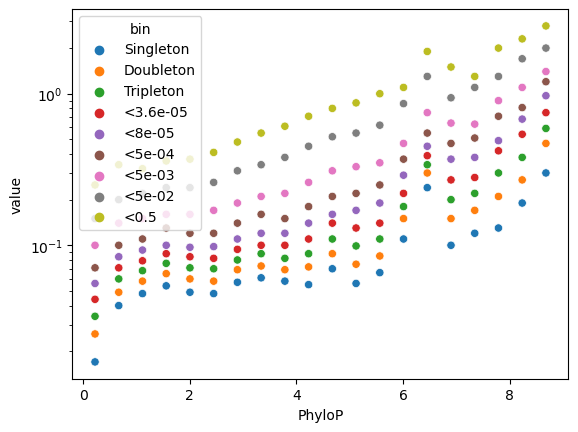

In [58]:
sns.scatterplot

sns.scatterplot(df_melt, x="PhyloP", y="value", hue="bin")
plt.yscale("log")



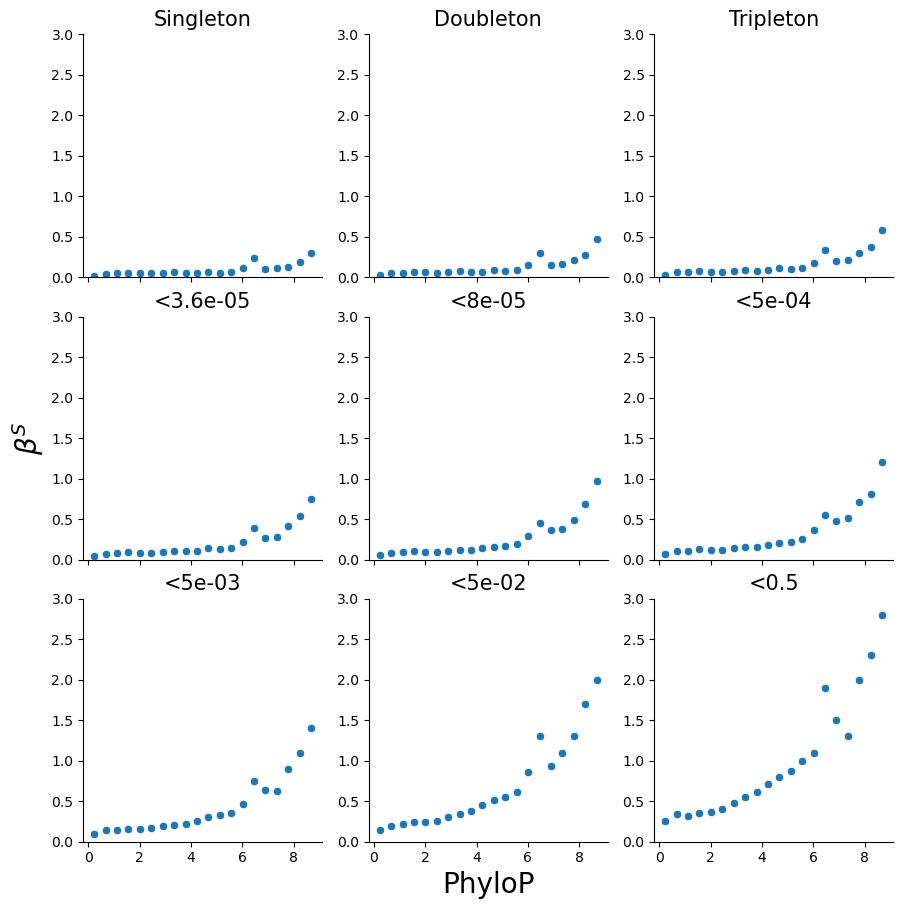

In [62]:
g = sns.FacetGrid(df_melt, col="bin", col_wrap=3, sharey = False)
g.map(sns.scatterplot, "PhyloP", "value")

g.set_titles("{col_name}", size= 15) 

g.set(ylim=(0, 3.0))


g.set_axis_labels("PhyloP", r"$\beta^S$", fontsize=20)

i = 0
for ax in g.axes.flat:
    if (i < 3) or (i > 5):    
        ax.set_ylabel('')
        
    if (i in [1, 4, 7]) == False:
        ax.set_xlabel('')
        
    i += 1
    
plt.savefig('multinomial_neutral_beta.pdf',dpi=300, bbox_inches = "tight", transparent=True)  

